In [2]:
"""
Reference: https://www.drivendata.co/blog/predict-pm25-benchmark/

We are going to use some of the explanations regarding satellite data processing with 
geo-location information to help pre-process the data.

The biggest problem with the data is that there are a lot of missing values (or NaN values)

"""
# File manipulation
import os

# Pandas and Numpy
import numpy as np
import pandas as pd

# Date time manipulation
from datetime import datetime, timedelta
from dateutil import parser
import time

# Tensorflow/Keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras.backend as backend
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor

# SKlearn
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

# Matplotlib
import matplotlib.pyplot as plt

# Geo data processing
import geopandas as gpd
from pyhdf.SD import SD, SDC, SDS
import pyproj
from pyproj import CRS, Proj
from typing import Union
from shapely.geometry import Point, Polygon

# Pickle
import pickle

# PQDM for parallel procesing
from pqdm.processes import pqdm


In [23]:
# Inspect one dataset
# We are going to take out some of the attributes we need to generate imputation values later
hdf = SD(os.path.join('train', '20180201T191000_maiac_la_0.hdf'))

for field, data in hdf.datasets().items():
    print(field, "->", data)
    
print("")

blue_band_AOD = hdf.select("Optical_Depth_047")
green_band_AOD = hdf.select("Optical_Depth_055")
aod_uncertainty = hdf.select("AOD_Uncertainty")
finemodefraction = hdf.select("FineModeFraction")
column_wv = hdf.select("Column_WV")
aod_qa = hdf.select("AOD_QA")
aod_model = hdf.select("AOD_MODEL")
injection_height = hdf.select("Injection_Height")
cosSZA = hdf.select("cosSZA")
cosVZA = hdf.select("cosVZA")
relAZ = hdf.select("RelAZ")
scattering_angle = hdf.select("Scattering_Angle")
glint_angle = hdf.select("Glint_Angle")

Optical_Depth_047 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 0)
Optical_Depth_055 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 1)
AOD_Uncertainty -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 2)
FineModeFraction -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 3)
Column_WV -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 22, 4)
AOD_QA -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 23, 5)
AOD_MODEL -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 21, 6)
Injection_Height -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (4, 1200, 1200), 5, 7)
cosSZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 8)
cosVZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 22, 9)
RelAZ -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (4, 240, 240), 2

In [4]:
raw_attr = hdf.attributes()["StructMetadata.0"] # Look at Metadata
print(raw_attr)
group_1 = raw_attr.split("END_GROUP=GRID_1")[0] # Pick out only 5km field in the metadata
# print(group_1)

hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except (NameError, ValueError, SyntaxError):
        hdf_metadata[key] = val

for key, value in hdf_metadata.items():
    print(key, '->', value)

print("")
    
# Note that coordinates are provided in meters
# We construct an alignment dictionary parameter
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

for key, value in alignment_dict.items():
    print(key, '->', value)


GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

In [7]:
##################
#DATA PROCESSING #
##################
# Loop over orbits to apply the attributes
def calibrate_data(dataset, shape, calibration_dict):
    """
    Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        if 'add_offset' not in calibration_dict:
            offset = 0
        else:
            offset = calibration_dict["add_offset"]
        if 'scale_factor' not in calibration_dict:
            scale_factor = 1
        else:
            scale_factor = calibration_dict["scale_factor"]
        data = (
            (data - offset) *
            scale_factor
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

calibration_dict = blue_band_AOD.attributes()
name, num_dim, shape, types, num_attr = blue_band_AOD.info()
# Test calibrate_data function
corrected_AOD = calibrate_data(blue_band_AOD, shape, calibration_dict)

In [8]:
# Aligning AOD data with real world coordinates
def create_meshgrid(alignment_dict, shape):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

xv, yv = create_meshgrid(alignment_dict, shape)

In [9]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

# Project sinu grid onto wgs84 grid
lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

In [10]:
def convert_array_to_df(
    corrected_arr,
    lat,
    lon,
    granule_id,
    crs,
    total_bounds = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

def plot_gdf(gdf, separate_bands=True, title='Blue Band AOD'):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle(title, fontsize=12)

(1203568, 4)
                       granule_id  orbit                     geometry  value
0  20180201T191000_maiac_la_0.hdf      0  POINT (-110.79078 35.36280)  0.110
1  20180201T191000_maiac_la_0.hdf      0  POINT (-110.78956 35.35446)  0.076
2  20180201T191000_maiac_la_0.hdf      0  POINT (-110.28947 35.28774)  0.112


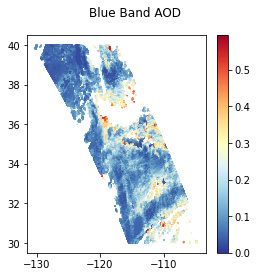

In [11]:
gdf = convert_array_to_df(corrected_AOD, lat, lon, '20180201T191000_maiac_la_0.hdf', wgs84_crs)
print(gdf.shape)
print(gdf.head(3))

plot_gdf(gdf, separate_bands=False)

In [14]:
# Some more helpful functions from the tutorial
def create_calibration_dict(data):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()

def create_alignment_dict(hdf):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

In [15]:
# Importing HDF data and creating a set of raw hdf files.
train_labels = pd.read_csv("train_labels.csv")
train_labels['Date'] = pd.to_datetime(train_labels['datetime'], format='%Y-%m-%d')
train_labels['Year'] = train_labels['Date'].dt.year
grid_metadata = pd.read_csv("grid_metadata.csv")
satellite_metadata = pd.read_csv("pm25_satellite_metadata.csv")
satellite_metadata['Date'] =  pd.to_datetime(satellite_metadata['time_end'], format='%Y-%m-%d')

la_gc = grid_metadata[grid_metadata['location'] == "Los Angeles (SoCAB)"].copy()
dl_gc = grid_metadata[grid_metadata['location'] == "Delhi"].copy()
tp_gc = grid_metadata[grid_metadata['location'] == "Taipei"].copy()

# Confirm all LA, Taipei, Delhi grid cells are in our training labels
assert la_gc['grid_id'].isin(train_labels.grid_id).all()
assert dl_gc['grid_id'].isin(train_labels.grid_id).all()
assert tp_gc['grid_id'].isin(train_labels.grid_id).all()

print("LA Grid Len:", len(la_gc))
print("Delhi Grid Len:", len(dl_gc))
print("Taipei Grid Len:", len(tp_gc))

print(train_labels.head(n=10))

# satellite_metadata = satellite_metadata[satellite_metadata.granule_id.str.endswith('f')]
# satellite_metadata = satellite_metadata[satellite_metadata['split'] == 'train']
# print(satellite_metadata)
# raw_hdf_set = set(satellite_metadata['granule_id'])

LA Grid Len: 14
Delhi Grid Len: 33
Taipei Grid Len: 7
               datetime grid_id  value                      Date  Year
0  2018-02-01T08:00:00Z   3S31A   11.4 2018-02-01 08:00:00+00:00  2018
1  2018-02-01T08:00:00Z   A2FBI   17.0 2018-02-01 08:00:00+00:00  2018
2  2018-02-01T08:00:00Z   DJN0F   11.1 2018-02-01 08:00:00+00:00  2018
3  2018-02-01T08:00:00Z   E5P9N   22.1 2018-02-01 08:00:00+00:00  2018
4  2018-02-01T08:00:00Z   FRITQ   29.8 2018-02-01 08:00:00+00:00  2018
5  2018-02-01T08:00:00Z   H96P6   12.8 2018-02-01 08:00:00+00:00  2018
6  2018-02-01T08:00:00Z   PG3MI   21.0 2018-02-01 08:00:00+00:00  2018
7  2018-02-01T08:00:00Z   QJHW4    5.2 2018-02-01 08:00:00+00:00  2018
8  2018-02-01T08:00:00Z   WT52R    6.5 2018-02-01 08:00:00+00:00  2018
9  2018-02-01T08:00:00Z   X5DKW   17.7 2018-02-01 08:00:00+00:00  2018


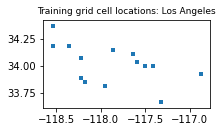

In [16]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

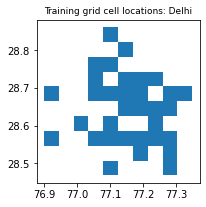

In [17]:
dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

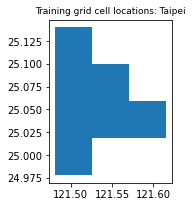

In [18]:
tp_polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs) # used for WGS 84
tp_polys.name = "geometry"
tp_polys_gdf = gpd.GeoDataFrame(tp_polys)

tp_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

In [19]:
# For pqdm if necessary
# !jupyter nbextension enable --py widgetsnbextension

In [20]:
# We split train_labels into train and cross validation

train_actual_labels = train_labels[train_labels['Year'] <= 2019].copy()
train_cross_val_labels = train_labels[train_labels['Year'] > 2019].copy()

# print(len(train_actual_labels.index))
# print(len(train_cross_val_labels.index))

# We randomly pick a few training data points to test the feature generation algorithm
n = 50
train_labels_subset = train_actual_labels.sample(n=n).copy()

def get_grid_data(metadata, grid_id):
    return metadata[metadata["grid_id"] == grid_id]

def fetch_satellite_meta(metadata, date_time, location, datatype, split):
    if location == "Delhi":
        location = "dl"
    elif location == "Taipei":
        location = "tpe"
    else:
        location = "la"

    metadata = metadata[metadata['location'] == location]
    metadata = metadata[metadata['product'] == datatype]
    metadata = metadata[metadata['split'] == split]
    dateobject = parser.parse(date_time)
    return metadata.loc[(metadata['Date'].dt.month == dateobject.month) & 
                        (metadata['Date'].dt.day == dateobject.day) &
                        (metadata['Date'].dt.year <= dateobject.year)]

def fetch_granule_id(grid_id, date_time, split):
    temp = get_grid_data(grid_metadata, grid_id)
    location = temp.iloc[0]['location']
    sat_met = fetch_satellite_meta(satellite_metadata, 
                               date_time, 
                               location, 
                               "maiac", 
                               split)
    granule_ids = []
    for i in range(len(sat_met)):
        granule_id = sat_met.iloc[i]['granule_id']
        granule_ids.append(granule_id)
            
    return granule_ids, location

def fetch_alignment_dictionary(hdf, field_name):
    raw_attr = hdf.attributes()["StructMetadata.0"]  # Look at Metadata
    text_array = raw_attr.split("END_GROUP=GRID_1")  # The alignment values are always the same for a given HDF
       
    group_1 = text_array[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

    # Parse expressions still wrapped in apostrophes
    for key, val in hdf_metadata.items():
        try:
            hdf_metadata[key] = eval(val)
        except (NameError, ValueError, SyntaxError):
            hdf_metadata[key] = val

            
    # Note that coordinates are provided in meters
    # We construct an alignment dictionary parameter
    alignment_dict = {
        "upper_left": hdf_metadata["UpperLeftPointMtrs"],
        "lower_right": hdf_metadata["LowerRightMtrs"],
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    
    return alignment_dict

def preprocess_maiac_data(granule_id, location, split, field_name):
    # print(granule_id, location, split, field_name)
    hdf = SD(os.path.join(split, granule_id))
    field = hdf.select(field_name)
    name, num_dim, shape, types, num_attr = field.info()
    if field_name in ['AOD_QA']:
        corrected_field = field
    else:
        calibration_dict = field.attributes()
        corrected_field = calibrate_data(field, shape, calibration_dict)
    alignment_dict = fetch_alignment_dictionary(hdf, field_name)
    xv, yv = create_meshgrid(alignment_dict, shape)
    sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
    wgs84_crs = CRS.from_epsg("4326")
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)
    
    if location == "Delhi":
        polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs)
    elif location == "Taipei":
        polys = gpd.GeoSeries.from_wkt(tp_gc.wkt, crs=wgs84_crs)
    else:
        polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs)
    
    polys.name = "geometry"
    polys_gdf = gpd.GeoDataFrame(polys)
    
    # xmin, ymin, xmax, ymax = polys_gdf.total_bounds
    gdf = convert_array_to_df(corrected_field, lat, lon, granule_id, wgs84_crs, polys_gdf.total_bounds)
    
    df = gpd.sjoin(polys_gdf, gdf, how="inner")
    
    hdf.end()
    
    return df.drop(columns="index_right").reset_index()

# Parallelize processes
# def preprocess_field_parallel(args, n_jobs=2):
#     args_sub = args[:2]
#     print(args_sub)
#     results = pqdm(args_sub, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
#     return pd.concat(results)

def generate_features(train_labels, split="train"):
    labels = []
    features = []
    args = []
    
    print("Length train_labels:", len(train_labels.index))
    for idx, i in enumerate(train_labels.index): 
        granule_ids, location = fetch_granule_id(train_labels.loc[i]['grid_id'], train_labels.loc[i]['datetime'], split)
    
        blueband_dataframe_list = []
        greenband_dataframe_list = []
        aod_uncertainty_dataframe_list = []
        finemodefraction_dataframe_list = []
        column_wv_dataframe_list = []
        injection_height_dataframe_list = []
#         aod_qa_dataframe_list = []
        
        for granule_id in granule_ids:
            result_blueband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_047'])
            result_greenband = preprocess_maiac_data(*[granule_id, location, split, 'Optical_Depth_055'])
            result_aod_uncertainty = preprocess_maiac_data(*[granule_id, location, split, 'AOD_Uncertainty'])
            result_finemodefraction = preprocess_maiac_data(*[granule_id, location, split, 'FineModeFraction'])
            result_column_wv = preprocess_maiac_data(*[granule_id, location, split, 'Column_WV'])
            result_injection_height = preprocess_maiac_data(*[granule_id, location, split, 'Injection_Height'])
#             result_aod_qa = preprocess_maiac_data(*[granule_id, location, split, 'AOD_QA'])
            
            blueband_dataframe_list.append(result_blueband)
            greenband_dataframe_list.append(result_greenband)
            aod_uncertainty_dataframe_list.append(result_aod_uncertainty)
            finemodefraction_dataframe_list.append(result_finemodefraction)
            column_wv_dataframe_list.append(result_column_wv)
            injection_height_dataframe_list.append(result_injection_height)
#             aod_qa_dataframe_list.append(result_aod_qa)
        
        combined_blueband_df = pd.concat(blueband_dataframe_list)
        combined_greenband_df = pd.concat(greenband_dataframe_list)
        combined_aod_uncertainty_df = pd.concat(aod_uncertainty_dataframe_list)
        combined_finemodefraction_df = pd.concat(finemodefraction_dataframe_list)
        combined_column_wv_df = pd.concat(column_wv_dataframe_list)
        combined_injection_height_df = pd.concat(injection_height_dataframe_list)
#         combined_aod_qa_df = pd.concat(aod_qa_dataframe_list)
        
        feature = []
        idx_offset = 3
        # Order of statistics: min, max, mean
        if combined_blueband_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_blueband_df['value'].min(), combined_blueband_df['value'].max(), 
                            combined_blueband_df['value'].mean()]) 
        
        if combined_greenband_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_greenband_df['value'].min(), combined_greenband_df['value'].max(), 
                            combined_greenband_df['value'].mean()]) 
        
        if combined_aod_uncertainty_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_aod_uncertainty_df['value'].min(), combined_aod_uncertainty_df['value'].max(), 
                            combined_aod_uncertainty_df['value'].mean()])
            
        if combined_finemodefraction_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_finemodefraction_df['value'].min(), combined_finemodefraction_df['value'].max(), 
                            combined_finemodefraction_df['value'].mean()])
            
        if combined_column_wv_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_column_wv_df['value'].min(), combined_column_wv_df['value'].max(), 
                            combined_column_wv_df['value'].mean()])
        
        if combined_injection_height_df.empty:
            feature.extend([np.nan] * idx_offset)
        else:
            feature.extend([combined_injection_height_df['value'].min(), combined_injection_height_df['value'].max(), 
                            combined_injection_height_df['value'].mean()])
        
#         if combined_aod_qa_df.empty:
#             feature.extend([np.nan, np.nan, np.nan])
#         else:
#             feature.extend([combined_aod_qa_df['value'].min(), combined_aod_qa_df['value'].max(), 
#                             combined_aod_qa_df['value'].mean()])
        
        label = train_labels.loc[i]['value']
        features.append(feature)
        labels.append(label)
        
    return features, labels, idx_offset

startTime = time.time()
features, labels, idx_offset = generate_features(train_labels_subset, "train")
endTime = time.time()
elapsedTime = endTime - startTime
print("Elapsed time: {}".format(str(timedelta(seconds=elapsedTime))))

Length train_labels: 50
Elapsed time: 0:22:08.808504


In [34]:
"""
Imputation and Scaler
"""

features_array = np.asarray(features)
labels_array = np.asarray(labels)

print(features_array.shape)
print(labels_array.shape)

# print(features_array)

# This function is a custom uniform random imputation function
# This should be updated based on how we generate the features in order to fill all the np.nan values with random valid values
# So if the feature list changes, we have to update this function
def custom_uniform_random_impute_function(features_array, idx_offset=3):
    idx = 0
    
    imputed_features_array = np.copy(features_array)
    
    # N columns are Blueband AOD
    calibration_dict = blue_band_AOD.attributes()
    blue_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of blue band AOD nan:", blue_band_features[np.isnan(blue_band_features)].size)
    blue_band_features[np.isnan(blue_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=blue_band_features[np.isnan(blue_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    blue_band_features = (blue_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    calibration_dict = green_band_AOD.attributes()
    green_band_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of green band AOD nan:", green_band_features[np.isnan(green_band_features)].size)
    green_band_features[np.isnan(green_band_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                           high=calibration_dict['valid_range'][1], 
                                                                           size=green_band_features[np.isnan(green_band_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    green_band_features = (green_band_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    calibration_dict = aod_uncertainty.attributes()
    aod_uncertainty_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of AOD Uncertainty nan:", aod_uncertainty_features[np.isnan(aod_uncertainty_features)].size)
    aod_uncertainty_features[np.isnan(aod_uncertainty_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                     high=calibration_dict['valid_range'][1], 
                                                                                     size=aod_uncertainty_features[np.isnan(aod_uncertainty_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    aod_uncertainty_features = (aod_uncertainty_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
    idx += idx_offset
    calibration_dict = finemodefraction.attributes()
    finemodefraction_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of FineModeFraction nan:", finemodefraction_features[np.isnan(finemodefraction_features)].size)
    finemodefraction_features[np.isnan(finemodefraction_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                       high=calibration_dict['valid_range'][1], 
                                                                                       size=finemodefraction_features[np.isnan(finemodefraction_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    finemodefraction_features = (finemodefraction_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    calibration_dict = column_wv.attributes()
    column_wv_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of Column WV nan:", column_wv_features[np.isnan(column_wv_features)].size)
    column_wv_features[np.isnan(column_wv_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                         high=calibration_dict['valid_range'][1], 
                                                                         size=column_wv_features[np.isnan(column_wv_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    column_wv_features = (column_wv_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
    idx += idx_offset
    calibration_dict = injection_height.attributes()
    injection_height_features = imputed_features_array[:, idx:idx+idx_offset]
    print("Number of Injection Height nan:", injection_height_features[np.isnan(injection_height_features)].size)
    injection_height_features[np.isnan(injection_height_features)] = np.random.uniform(low=calibration_dict['valid_range'][0], 
                                                                                       high=calibration_dict['valid_range'][1], 
                                                                                       size=injection_height_features[np.isnan(injection_height_features)].shape)
    if 'add_offset' in calibration_dict:
        offset = calibration_dict['add_offset']
    else:
        offset = 0
    if 'scale_factor' in calibration_dict:
        scale = calibration_dict['scale_factor']
    else:
        scale = 1
    injection_height_features = (injection_height_features - offset) * scale
    imputed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return imputed_features_array
    
imputed_features_array = custom_uniform_random_impute_function(features_array, idx_offset=idx_offset)

# print(imputed_features_array)
print(imputed_features_array.shape)

# This function is a custom Min Max Scaler function
# This should be updated based on how we generate the features
# So if the feature list changes, we have to update this function
def custom_MinMaxScaler_function(features_array, idx_offset=3):
    # y = (x – min) / (max – min)
    idx = 0
    
    transformed_features_array = np.copy(features_array)
    
    min_max_pair_list = []
    
    # N columns are Blueband AOD
    blue_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(blue_band_features)
    max_val = np.amax(blue_band_features)
    blue_band_features = (blue_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = blue_band_features
    
    # N columns are Greenband AOD
    idx += idx_offset
    green_band_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(green_band_features)
    max_val = np.amax(green_band_features)
    green_band_features = (green_band_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = green_band_features
    
    # N columns are AOD Uncertainty
    idx += idx_offset
    aod_uncertainty_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(aod_uncertainty_features)
    max_val = np.amax(aod_uncertainty_features)
    aod_uncertainty_features = (aod_uncertainty_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = aod_uncertainty_features
    
    # N columns are FineModeFraction
    idx += idx_offset
    finemodefraction_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(finemodefraction_features)
    max_val = np.amax(finemodefraction_features)
    finemodefraction_features = (finemodefraction_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = finemodefraction_features
    
    # N columns are Column WV
    idx += idx_offset
    column_wv_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(column_wv_features)
    max_val = np.amax(column_wv_features)
    column_wv_features = (column_wv_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = column_wv_features
    
    # N columns are Injection Height
    idx += idx_offset
    injection_height_features = transformed_features_array[:, idx:idx+idx_offset]
    min_val = np.amin(injection_height_features)
    max_val = np.amax(injection_height_features)
    injection_height_features = (injection_height_features - min_val)/(max_val - min_val)
    min_max_pair_list.append((min_val, max_val))
    transformed_features_array[:, idx:idx+idx_offset] = injection_height_features
    
    return transformed_features_array, min_max_pair_list

transformed_features_array, min_max_pair_list = custom_MinMaxScaler_function(imputed_features_array, idx_offset=idx_offset)

# print(transformed_features_array)
print(transformed_features_array.shape)
print(min_max_pair_list)

(50, 18)
(50,)
Number of blue band AOD nan: 18
Number of green band AOD nan: 18
Number of AOD Uncertainty nan: 0
Number of FineModeFraction nan: 150
Number of Column WV nan: 0
Number of Injection Height nan: 120
(50, 18)
(50, 18)
[(-0.05626387750736651, 4.248271001591118), (1.4e-05, 4.353111064797329), (3.7000000000000006e-07, 0.00023512), (0.007492323690350466, 0.9990867340642526), (5.2000000000000004e-05, 0.006955), (0.8122370839118958, 9975.050599490023)]


In [30]:
def flat_dense_model():  
    model = Sequential()
    model.add(Dense(18, activation='relu', input_shape=(18,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = flat_dense_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 18)                342       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                190       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [38]:
print(type(transformed_features_array))
print(type(labels_array))

# For testing
history = model.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 2/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 3/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 4/2500
3/3 [==============================] - 0s 659us/step - loss: 10905.5771
Epoch 5/2500
3/3 [==============================] - 0s 665us/step - loss: 10905.5771
Epoch 6/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 7/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 8/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 9/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 10/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 11/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 12/2500
3/3

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 94/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 95/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 96/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 97/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 98/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 99/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 100/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 101/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 102/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 103/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 104/2500
3/3 [==============================] - 0s 1000us

3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 188/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 189/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 190/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 191/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 192/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 193/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 194/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 195/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 196/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 197/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 198/2500
3/3 [==============================] - 0s 1000

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 282/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 283/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 284/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 285/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5791
Epoch 286/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 287/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 288/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 289/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 290/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 291/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 292/2500
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 999us/step - loss: 10905.5762
Epoch 376/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 377/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 378/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 379/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 380/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 381/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 382/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5762
Epoch 383/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 384/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 385/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 386/2500
3/3 [==============================] - 0s 66

3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 470/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 471/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 472/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 473/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 474/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 475/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 476/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 477/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 478/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 479/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 480/2500
3/3 [==============================] - 0s 3

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 564/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 565/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 566/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 567/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 568/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 569/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 570/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 571/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 572/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5791
Epoch 573/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 574/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 658/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 659/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 660/2500
3/3 [==============================] - 0s 2ms/step - loss: 10905.5771
Epoch 661/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 662/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 663/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 664/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 665/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 666/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 667/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 668/2500
3/3 [==============================] - 0s 667u

3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 752/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5791
Epoch 753/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 754/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 755/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 756/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 757/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 758/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 759/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 760/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 761/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 762/2500
3/3 [==============================] - 0s 666

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 846/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 847/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 848/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 849/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 850/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 851/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 852/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 853/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 854/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 855/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 856/2500
3/3 [==============================] - 0s 1000us

3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 940/2500
3/3 [==============================] - 0s 884us/step - loss: 10905.5791
Epoch 941/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 942/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 943/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 944/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 945/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 946/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 947/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 948/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 949/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 950/2500
3/3 [==============================] - 0s 66

3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1034/2500
3/3 [==============================] - 0s 843us/step - loss: 10905.5771
Epoch 1035/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1036/2500
3/3 [==============================] - 0s 695us/step - loss: 10905.5771
Epoch 1037/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1038/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1039/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1040/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1041/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1042/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1043/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 1044/2500
3/3 [=========================

3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1127/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1128/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1129/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1130/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1131/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1132/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5791
Epoch 1133/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1134/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1135/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1136/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1137/2500
3/3 [==============================

3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1220/2500
3/3 [==============================] - 0s 668us/step - loss: 10905.5791
Epoch 1221/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1222/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 1223/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1224/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 1225/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1226/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1227/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1228/2500
3/3 [==============================] - 0s 329us/step - loss: 10905.5771
Epoch 1229/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1230/2500
3/3 [=============================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1313/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1314/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1315/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1316/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1317/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1318/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1319/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1320/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1321/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 1322/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1323/2500
3/3 [============================

3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1406/2500
3/3 [==============================] - 0s 364us/step - loss: 10905.5771
Epoch 1407/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1408/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1409/2500
3/3 [==============================] - 0s 663us/step - loss: 10905.5771
Epoch 1410/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1411/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1412/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1413/2500
3/3 [==============================] - 0s 831us/step - loss: 10905.5771
Epoch 1414/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1415/2500
3/3 [==============================] - 0s 684us/step - loss: 10905.5762
Epoch 1416/2500
3/3 [===========================

3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1499/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1500/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 1501/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1502/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1503/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1504/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1505/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1506/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1507/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1508/2500
3/3 [==============================] - 0s 626us/step - loss: 10905.5771
Epoch 1509/2500
3/3 [===========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1592/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1593/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1594/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1595/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1596/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1597/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1598/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1599/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1600/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1601/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1602/2500
3/3 [===========================

3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1685/2500
3/3 [==============================] - 0s 685us/step - loss: 10905.5771
Epoch 1686/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1687/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1688/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1689/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1690/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1691/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1692/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1693/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1694/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1695/2500
3/3 [==========================

3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1778/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1779/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1780/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1781/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1782/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1783/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1784/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1785/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 1786/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 1787/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1788/2500
3/3 [==========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1871/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 1872/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1873/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1874/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1875/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1876/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1877/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1878/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1879/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1880/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1881/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 1964/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1965/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1966/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5762
Epoch 1967/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1968/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1969/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5791
Epoch 1970/2500
3/3 [==============================] - 0s 999us/step - loss: 10905.5771
Epoch 1971/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 1972/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 1973/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 1974/2500
3/3 [============================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2057/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2058/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2059/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2060/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 2061/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2062/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2063/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 2064/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2065/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 2066/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5791
Epoch 2067/2500
3/3 [===========================

3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2150/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2151/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5762
Epoch 2152/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2153/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5791
Epoch 2154/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2155/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2156/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2157/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2158/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2159/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2160/2500
3/3 [========================

3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2243/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2244/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2245/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2246/2500
3/3 [==============================] - 0s 333us/step - loss: 10905.5771
Epoch 2247/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 2248/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2249/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2250/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2251/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2252/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2253/2500
3/3 [===========================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2336/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2337/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2338/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2339/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2340/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2341/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2342/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2343/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2344/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2345/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 2346/2500
3/3 [============================

3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2429/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2430/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2431/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5762
Epoch 2432/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2433/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2434/2500
3/3 [==============================] - 0s 667us/step - loss: 10905.5771
Epoch 2435/2500
3/3 [==============================] - 0s 1000us/step - loss: 10905.5771
Epoch 2436/2500
3/3 [==============================] - 0s 1ms/step - loss: 10905.5771
Epoch 2437/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5771
Epoch 2438/2500
3/3 [==============================] - 0s 666us/step - loss: 10905.5791
Epoch 2439/2500
3/3 [===========================

In [32]:
def flat_dense_model_dropout_input():  
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(18,)))
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(10, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(5, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model_dropout_input = flat_dense_model_dropout_input()
model_dropout_input.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                1140      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
____________________________________________________

In [39]:
# For testing
history = model_dropout_input.fit(transformed_features_array, labels_array, epochs=2500, batch_size=20)

Epoch 1/2500
3/3 [==============================] - 0s 667us/step - loss: 1006.3336
Epoch 2/2500
3/3 [==============================] - 0s 666us/step - loss: 935.5483
Epoch 3/2500
3/3 [==============================] - 0s 667us/step - loss: 2250.9529
Epoch 4/2500
3/3 [==============================] - 0s 661us/step - loss: 1420.2809
Epoch 5/2500
3/3 [==============================] - 0s 667us/step - loss: 1555.1606
Epoch 6/2500
3/3 [==============================] - 0s 1ms/step - loss: 999.1057
Epoch 7/2500
3/3 [==============================] - 0s 667us/step - loss: 2520.0212
Epoch 8/2500
3/3 [==============================] - 0s 666us/step - loss: 1008.4487
Epoch 9/2500
3/3 [==============================] - 0s 993us/step - loss: 989.0268
Epoch 10/2500
3/3 [==============================] - 0s 997us/step - loss: 1472.0732
Epoch 11/2500
3/3 [==============================] - 0s 994us/step - loss: 2238.3245
Epoch 12/2500
3/3 [==============================] - 0s 666us/step - loss: 854.

3/3 [==============================] - 0s 1ms/step - loss: 2904.9104
Epoch 99/2500
3/3 [==============================] - 0s 666us/step - loss: 1360.9720
Epoch 100/2500
3/3 [==============================] - 0s 1000us/step - loss: 1464.7784
Epoch 101/2500
3/3 [==============================] - 0s 667us/step - loss: 637.6503
Epoch 102/2500
3/3 [==============================] - 0s 667us/step - loss: 2774.4954
Epoch 103/2500
3/3 [==============================] - 0s 1ms/step - loss: 1250.3140
Epoch 104/2500
3/3 [==============================] - 0s 667us/step - loss: 2510.1743
Epoch 105/2500
3/3 [==============================] - 0s 666us/step - loss: 564.3223
Epoch 106/2500
3/3 [==============================] - 0s 666us/step - loss: 2135.0669
Epoch 107/2500
3/3 [==============================] - 0s 666us/step - loss: 1575.3916
Epoch 108/2500
3/3 [==============================] - 0s 666us/step - loss: 2305.4766
Epoch 109/2500
3/3 [==============================] - 0s 666us/step - loss:

Epoch 194/2500
3/3 [==============================] - 0s 667us/step - loss: 2392.5242
Epoch 195/2500
3/3 [==============================] - 0s 1000us/step - loss: 596.1498
Epoch 196/2500
3/3 [==============================] - 0s 1ms/step - loss: 792.7324
Epoch 197/2500
3/3 [==============================] - 0s 666us/step - loss: 652.2695
Epoch 198/2500
3/3 [==============================] - 0s 666us/step - loss: 2540.1609
Epoch 199/2500
3/3 [==============================] - 0s 1ms/step - loss: 1051.6969
Epoch 200/2500
3/3 [==============================] - 0s 666us/step - loss: 1448.1910
Epoch 201/2500
3/3 [==============================] - 0s 1000us/step - loss: 1860.3525
Epoch 202/2500
3/3 [==============================] - 0s 1ms/step - loss: 1150.2821
Epoch 203/2500
3/3 [==============================] - 0s 1000us/step - loss: 1278.2418
Epoch 204/2500
3/3 [==============================] - 0s 333us/step - loss: 2259.2878
Epoch 205/2500
3/3 [==============================] - 0s 667

3/3 [==============================] - 0s 667us/step - loss: 619.6792
Epoch 290/2500
3/3 [==============================] - 0s 666us/step - loss: 1406.8939
Epoch 291/2500
3/3 [==============================] - 0s 1000us/step - loss: 424.5463
Epoch 292/2500
3/3 [==============================] - 0s 333us/step - loss: 646.1332
Epoch 293/2500
3/3 [==============================] - 0s 667us/step - loss: 1326.2544
Epoch 294/2500
3/3 [==============================] - 0s 667us/step - loss: 3442.1221
Epoch 295/2500
3/3 [==============================] - 0s 666us/step - loss: 2095.1074
Epoch 296/2500
3/3 [==============================] - 0s 666us/step - loss: 1470.4689
Epoch 297/2500
3/3 [==============================] - 0s 666us/step - loss: 1759.9661
Epoch 298/2500
3/3 [==============================] - 0s 333us/step - loss: 2980.5425
Epoch 299/2500
3/3 [==============================] - 0s 666us/step - loss: 698.1418
Epoch 300/2500
3/3 [==============================] - 0s 666us/step - lo

3/3 [==============================] - 0s 666us/step - loss: 685.2085
Epoch 386/2500
3/3 [==============================] - 0s 667us/step - loss: 910.6062
Epoch 387/2500
3/3 [==============================] - 0s 993us/step - loss: 976.3480
Epoch 388/2500
3/3 [==============================] - 0s 667us/step - loss: 643.6349
Epoch 389/2500
3/3 [==============================] - 0s 2ms/step - loss: 932.2125
Epoch 390/2500
3/3 [==============================] - 0s 999us/step - loss: 1014.0208
Epoch 391/2500
3/3 [==============================] - 0s 666us/step - loss: 691.9714
Epoch 392/2500
3/3 [==============================] - 0s 660us/step - loss: 549.0397
Epoch 393/2500
3/3 [==============================] - 0s 1000us/step - loss: 1934.2599
Epoch 394/2500
3/3 [==============================] - 0s 666us/step - loss: 1242.8440
Epoch 395/2500
3/3 [==============================] - 0s 333us/step - loss: 1157.7939
Epoch 396/2500
3/3 [==============================] - 0s 994us/step - loss: 7

3/3 [==============================] - 0s 667us/step - loss: 1737.2568
Epoch 482/2500
3/3 [==============================] - 0s 665us/step - loss: 744.5982
Epoch 483/2500
3/3 [==============================] - 0s 666us/step - loss: 593.8342
Epoch 484/2500
3/3 [==============================] - 0s 661us/step - loss: 980.6691
Epoch 485/2500
3/3 [==============================] - 0s 666us/step - loss: 613.6317
Epoch 486/2500
3/3 [==============================] - 0s 1000us/step - loss: 1827.1112
Epoch 487/2500
3/3 [==============================] - 0s 672us/step - loss: 798.7363
Epoch 488/2500
3/3 [==============================] - 0s 1000us/step - loss: 2017.2539
Epoch 489/2500
3/3 [==============================] - 0s 666us/step - loss: 3298.0322
Epoch 490/2500
3/3 [==============================] - 0s 666us/step - loss: 749.0302
Epoch 491/2500
3/3 [==============================] - 0s 666us/step - loss: 825.8464
Epoch 492/2500
3/3 [==============================] - 0s 667us/step - loss

3/3 [==============================] - 0s 1000us/step - loss: 906.0270
Epoch 578/2500
3/3 [==============================] - 0s 666us/step - loss: 1428.3335
Epoch 579/2500
3/3 [==============================] - 0s 999us/step - loss: 873.2500
Epoch 580/2500
3/3 [==============================] - 0s 666us/step - loss: 1640.4509
Epoch 581/2500
3/3 [==============================] - 0s 1000us/step - loss: 961.6248
Epoch 582/2500
3/3 [==============================] - 0s 999us/step - loss: 678.2782
Epoch 583/2500
3/3 [==============================] - 0s 666us/step - loss: 489.4071
Epoch 584/2500
3/3 [==============================] - 0s 999us/step - loss: 2611.5344
Epoch 585/2500
3/3 [==============================] - 0s 1000us/step - loss: 3022.3547
Epoch 586/2500
3/3 [==============================] - 0s 666us/step - loss: 1359.7444
Epoch 587/2500
3/3 [==============================] - 0s 1000us/step - loss: 4122.5293
Epoch 588/2500
3/3 [==============================] - 0s 666us/step - 

3/3 [==============================] - 0s 666us/step - loss: 945.3475
Epoch 673/2500
3/3 [==============================] - 0s 1ms/step - loss: 1391.9733
Epoch 674/2500
3/3 [==============================] - 0s 667us/step - loss: 734.1831
Epoch 675/2500
3/3 [==============================] - 0s 666us/step - loss: 1758.1282
Epoch 676/2500
3/3 [==============================] - 0s 666us/step - loss: 947.6486
Epoch 677/2500
3/3 [==============================] - 0s 1000us/step - loss: 478.6459
Epoch 678/2500
3/3 [==============================] - 0s 666us/step - loss: 921.1161
Epoch 679/2500
3/3 [==============================] - 0s 1ms/step - loss: 899.9130
Epoch 680/2500
3/3 [==============================] - 0s 1000us/step - loss: 655.0090
Epoch 681/2500
3/3 [==============================] - 0s 666us/step - loss: 1162.8193
Epoch 682/2500
3/3 [==============================] - 0s 999us/step - loss: 860.8401
Epoch 683/2500
3/3 [==============================] - 0s 666us/step - loss: 678

3/3 [==============================] - 0s 667us/step - loss: 1166.1233
Epoch 769/2500
3/3 [==============================] - 0s 2ms/step - loss: 1397.8378
Epoch 770/2500
3/3 [==============================] - 0s 1ms/step - loss: 1709.6820
Epoch 771/2500
3/3 [==============================] - 0s 667us/step - loss: 1969.7991
Epoch 772/2500
3/3 [==============================] - 0s 667us/step - loss: 1452.6580
Epoch 773/2500
3/3 [==============================] - 0s 1000us/step - loss: 1046.3735
Epoch 774/2500
3/3 [==============================] - 0s 667us/step - loss: 785.5737
Epoch 775/2500
3/3 [==============================] - 0s 1000us/step - loss: 2108.2769
Epoch 776/2500
3/3 [==============================] - 0s 1ms/step - loss: 694.3192
Epoch 777/2500
3/3 [==============================] - 0s 667us/step - loss: 1364.6466
Epoch 778/2500
3/3 [==============================] - 0s 667us/step - loss: 1280.1686
Epoch 779/2500
3/3 [==============================] - 0s 666us/step - loss:

Epoch 864/2500
3/3 [==============================] - 0s 667us/step - loss: 1244.7130
Epoch 865/2500
3/3 [==============================] - 0s 666us/step - loss: 820.0018
Epoch 866/2500
3/3 [==============================] - 0s 666us/step - loss: 2284.1255
Epoch 867/2500
3/3 [==============================] - 0s 2ms/step - loss: 1185.4862
Epoch 868/2500
3/3 [==============================] - 0s 882us/step - loss: 867.3178
Epoch 869/2500
3/3 [==============================] - 0s 667us/step - loss: 1036.4957
Epoch 870/2500
3/3 [==============================] - 0s 1000us/step - loss: 1479.4219
Epoch 871/2500
3/3 [==============================] - 0s 666us/step - loss: 1646.4321
Epoch 872/2500
3/3 [==============================] - 0s 666us/step - loss: 1069.9824
Epoch 873/2500
3/3 [==============================] - 0s 666us/step - loss: 1774.6160
Epoch 874/2500
3/3 [==============================] - 0s 1ms/step - loss: 853.7406
Epoch 875/2500
3/3 [==============================] - 0s 1ms

Epoch 960/2500
3/3 [==============================] - 0s 672us/step - loss: 1128.3104
Epoch 961/2500
3/3 [==============================] - 0s 666us/step - loss: 2568.5281
Epoch 962/2500
3/3 [==============================] - 0s 666us/step - loss: 910.1555
Epoch 963/2500
3/3 [==============================] - 0s 666us/step - loss: 2244.5276
Epoch 964/2500
3/3 [==============================] - 0s 1000us/step - loss: 1542.2842
Epoch 965/2500
3/3 [==============================] - 0s 666us/step - loss: 1178.0088
Epoch 966/2500
3/3 [==============================] - 0s 666us/step - loss: 843.1231
Epoch 967/2500
3/3 [==============================] - 0s 672us/step - loss: 1415.4644
Epoch 968/2500
3/3 [==============================] - 0s 660us/step - loss: 827.5142
Epoch 969/2500
3/3 [==============================] - 0s 666us/step - loss: 766.4684
Epoch 970/2500
3/3 [==============================] - 0s 1000us/step - loss: 801.7626
Epoch 971/2500
3/3 [==============================] - 0s 

3/3 [==============================] - 0s 666us/step - loss: 957.3992
Epoch 1056/2500
3/3 [==============================] - 0s 672us/step - loss: 503.1528
Epoch 1057/2500
3/3 [==============================] - 0s 999us/step - loss: 1108.3035
Epoch 1058/2500
3/3 [==============================] - 0s 1ms/step - loss: 1781.2551
Epoch 1059/2500
3/3 [==============================] - 0s 999us/step - loss: 1536.8375
Epoch 1060/2500
3/3 [==============================] - 0s 1000us/step - loss: 860.4775
Epoch 1061/2500
3/3 [==============================] - 0s 666us/step - loss: 582.9722
Epoch 1062/2500
3/3 [==============================] - 0s 667us/step - loss: 609.9256
Epoch 1063/2500
3/3 [==============================] - 0s 1ms/step - loss: 2849.1372
Epoch 1064/2500
3/3 [==============================] - 0s 1ms/step - loss: 1344.9811
Epoch 1065/2500
3/3 [==============================] - 0s 1ms/step - loss: 940.5711
Epoch 1066/2500
3/3 [==============================] - 0s 1000us/step - 

3/3 [==============================] - 0s 666us/step - loss: 856.7216
Epoch 1151/2500
3/3 [==============================] - 0s 666us/step - loss: 1038.4783
Epoch 1152/2500
3/3 [==============================] - 0s 1ms/step - loss: 1056.0375
Epoch 1153/2500
3/3 [==============================] - 0s 666us/step - loss: 458.3732
Epoch 1154/2500
3/3 [==============================] - 0s 666us/step - loss: 924.4748
Epoch 1155/2500
3/3 [==============================] - 0s 667us/step - loss: 647.4751
Epoch 1156/2500
3/3 [==============================] - 0s 666us/step - loss: 1049.0811
Epoch 1157/2500
3/3 [==============================] - 0s 666us/step - loss: 814.7964
Epoch 1158/2500
3/3 [==============================] - 0s 999us/step - loss: 1372.6171
Epoch 1159/2500
3/3 [==============================] - 0s 999us/step - loss: 1478.1681
Epoch 1160/2500
3/3 [==============================] - 0s 666us/step - loss: 2542.7576
Epoch 1161/2500
3/3 [==============================] - 0s 999us/st

3/3 [==============================] - 0s 667us/step - loss: 692.6147
Epoch 1246/2500
3/3 [==============================] - 0s 666us/step - loss: 942.9155
Epoch 1247/2500
3/3 [==============================] - 0s 1000us/step - loss: 630.7603
Epoch 1248/2500
3/3 [==============================] - 0s 999us/step - loss: 967.1205
Epoch 1249/2500
3/3 [==============================] - 0s 667us/step - loss: 1623.7703
Epoch 1250/2500
3/3 [==============================] - 0s 1000us/step - loss: 819.4045
Epoch 1251/2500
3/3 [==============================] - 0s 666us/step - loss: 1097.3757
Epoch 1252/2500
3/3 [==============================] - 0s 666us/step - loss: 528.7582
Epoch 1253/2500
3/3 [==============================] - 0s 667us/step - loss: 2215.1738
Epoch 1254/2500
3/3 [==============================] - 0s 666us/step - loss: 557.7606
Epoch 1255/2500
3/3 [==============================] - 0s 667us/step - loss: 1131.4187
Epoch 1256/2500
3/3 [==============================] - 0s 666us/

Epoch 1340/2500
3/3 [==============================] - 0s 667us/step - loss: 1888.9844
Epoch 1341/2500
3/3 [==============================] - 0s 666us/step - loss: 1085.9242
Epoch 1342/2500
3/3 [==============================] - 0s 667us/step - loss: 889.6906
Epoch 1343/2500
3/3 [==============================] - 0s 661us/step - loss: 1649.8696
Epoch 1344/2500
3/3 [==============================] - 0s 667us/step - loss: 1176.2758
Epoch 1345/2500
3/3 [==============================] - 0s 1ms/step - loss: 1043.3604
Epoch 1346/2500
3/3 [==============================] - 0s 1ms/step - loss: 451.4657
Epoch 1347/2500
3/3 [==============================] - 0s 661us/step - loss: 2077.4333
Epoch 1348/2500
3/3 [==============================] - 0s 667us/step - loss: 1205.1254
Epoch 1349/2500
3/3 [==============================] - 0s 666us/step - loss: 587.0696
Epoch 1350/2500
3/3 [==============================] - 0s 666us/step - loss: 529.6921
Epoch 1351/2500
3/3 [==============================

3/3 [==============================] - 0s 1ms/step - loss: 845.0110
Epoch 1435/2500
3/3 [==============================] - 0s 666us/step - loss: 671.5460
Epoch 1436/2500
3/3 [==============================] - 0s 1000us/step - loss: 912.4796
Epoch 1437/2500
3/3 [==============================] - 0s 1000us/step - loss: 860.1149
Epoch 1438/2500
3/3 [==============================] - 0s 666us/step - loss: 1510.3938
Epoch 1439/2500
3/3 [==============================] - 0s 999us/step - loss: 1294.9452
Epoch 1440/2500
3/3 [==============================] - 0s 1ms/step - loss: 931.1237
Epoch 1441/2500
3/3 [==============================] - 0s 666us/step - loss: 623.5856
Epoch 1442/2500
3/3 [==============================] - 0s 999us/step - loss: 579.5590
Epoch 1443/2500
3/3 [==============================] - 0s 667us/step - loss: 2029.2173
Epoch 1444/2500
3/3 [==============================] - 0s 667us/step - loss: 840.5006
Epoch 1445/2500
3/3 [==============================] - 0s 666us/step 

3/3 [==============================] - 0s 666us/step - loss: 1821.7152
Epoch 1529/2500
3/3 [==============================] - 0s 667us/step - loss: 654.8994
Epoch 1530/2500
3/3 [==============================] - 0s 664us/step - loss: 1880.1039
Epoch 1531/2500
3/3 [==============================] - 0s 667us/step - loss: 541.2850
Epoch 1532/2500
3/3 [==============================] - 0s 1000us/step - loss: 1058.3855
Epoch 1533/2500
3/3 [==============================] - 0s 666us/step - loss: 2224.1135
Epoch 1534/2500
3/3 [==============================] - 0s 666us/step - loss: 1387.6283
Epoch 1535/2500
3/3 [==============================] - 0s 666us/step - loss: 893.5416
Epoch 1536/2500
3/3 [==============================] - 0s 666us/step - loss: 1145.4204
Epoch 1537/2500
3/3 [==============================] - 0s 666us/step - loss: 1160.9358
Epoch 1538/2500
3/3 [==============================] - 0s 999us/step - loss: 1101.1290
Epoch 1539/2500
3/3 [==============================] - 0s 666

3/3 [==============================] - 0s 1000us/step - loss: 3073.8818
Epoch 1623/2500
3/3 [==============================] - 0s 667us/step - loss: 825.1105
Epoch 1624/2500
3/3 [==============================] - 0s 1000us/step - loss: 894.8467
Epoch 1625/2500
3/3 [==============================] - 0s 667us/step - loss: 583.0835
Epoch 1626/2500
3/3 [==============================] - 0s 1000us/step - loss: 931.8271
Epoch 1627/2500
3/3 [==============================] - 0s 999us/step - loss: 2336.9451
Epoch 1628/2500
3/3 [==============================] - 0s 666us/step - loss: 1343.6925
Epoch 1629/2500
3/3 [==============================] - 0s 666us/step - loss: 1046.8823
Epoch 1630/2500
3/3 [==============================] - 0s 667us/step - loss: 791.5284
Epoch 1631/2500
3/3 [==============================] - 0s 1000us/step - loss: 847.0550
Epoch 1632/2500
3/3 [==============================] - 0s 667us/step - loss: 1034.1792
Epoch 1633/2500
3/3 [==============================] - 0s 1ms

3/3 [==============================] - 0s 666us/step - loss: 1365.5831
Epoch 1717/2500
3/3 [==============================] - 0s 666us/step - loss: 682.8502
Epoch 1718/2500
3/3 [==============================] - 0s 2ms/step - loss: 1934.2401
Epoch 1719/2500
3/3 [==============================] - 0s 1000us/step - loss: 878.0038
Epoch 1720/2500
3/3 [==============================] - 0s 1000us/step - loss: 733.1642
Epoch 1721/2500
3/3 [==============================] - 0s 667us/step - loss: 608.9747
Epoch 1722/2500
3/3 [==============================] - 0s 666us/step - loss: 406.4883
Epoch 1723/2500
3/3 [==============================] - 0s 666us/step - loss: 988.1142
Epoch 1724/2500
3/3 [==============================] - 0s 666us/step - loss: 1308.3015
Epoch 1725/2500
3/3 [==============================] - 0s 667us/step - loss: 885.6440
Epoch 1726/2500
3/3 [==============================] - 0s 1000us/step - loss: 716.2988
Epoch 1727/2500
3/3 [==============================] - 0s 667us/st

3/3 [==============================] - 0s 666us/step - loss: 981.2335
Epoch 1811/2500
3/3 [==============================] - 0s 1000us/step - loss: 650.0850
Epoch 1812/2500
3/3 [==============================] - 0s 1ms/step - loss: 1156.6519
Epoch 1813/2500
3/3 [==============================] - 0s 999us/step - loss: 1000.5807
Epoch 1814/2500
3/3 [==============================] - 0s 1000us/step - loss: 888.2600
Epoch 1815/2500
3/3 [==============================] - 0s 1000us/step - loss: 3040.8118
Epoch 1816/2500
3/3 [==============================] - 0s 667us/step - loss: 707.0064
Epoch 1817/2500
3/3 [==============================] - 0s 666us/step - loss: 746.0589
Epoch 1818/2500
3/3 [==============================] - 0s 666us/step - loss: 721.5182
Epoch 1819/2500
3/3 [==============================] - 0s 1000us/step - loss: 1014.1038
Epoch 1820/2500
3/3 [==============================] - 0s 667us/step - loss: 988.1851
Epoch 1821/2500
3/3 [==============================] - 0s 1ms/st

3/3 [==============================] - 0s 666us/step - loss: 640.1412
Epoch 1906/2500
3/3 [==============================] - 0s 999us/step - loss: 858.4917
Epoch 1907/2500
3/3 [==============================] - 0s 666us/step - loss: 388.7139
Epoch 1908/2500
3/3 [==============================] - 0s 999us/step - loss: 1491.3555
Epoch 1909/2500
3/3 [==============================] - 0s 666us/step - loss: 1576.5389
Epoch 1910/2500
3/3 [==============================] - 0s 1000us/step - loss: 1338.2925
Epoch 1911/2500
3/3 [==============================] - 0s 1000us/step - loss: 1036.6829
Epoch 1912/2500
3/3 [==============================] - 0s 667us/step - loss: 1918.5320
Epoch 1913/2500
3/3 [==============================] - 0s 1ms/step - loss: 679.1223
Epoch 1914/2500
3/3 [==============================] - 0s 1000us/step - loss: 447.7549
Epoch 1915/2500
3/3 [==============================] - 0s 667us/step - loss: 1337.6282
Epoch 1916/2500
3/3 [==============================] - 0s 667us

Epoch 2000/2500
3/3 [==============================] - 0s 1000us/step - loss: 1039.8492
Epoch 2001/2500
3/3 [==============================] - 0s 999us/step - loss: 1693.9276
Epoch 2002/2500
3/3 [==============================] - 0s 667us/step - loss: 1429.7993
Epoch 2003/2500
3/3 [==============================] - 0s 667us/step - loss: 2649.9971
Epoch 2004/2500
3/3 [==============================] - 0s 666us/step - loss: 559.5867
Epoch 2005/2500
3/3 [==============================] - 0s 666us/step - loss: 602.4471
Epoch 2006/2500
3/3 [==============================] - 0s 2ms/step - loss: 1942.3960
Epoch 2007/2500
3/3 [==============================] - 0s 999us/step - loss: 775.4546
Epoch 2008/2500
3/3 [==============================] - 0s 1000us/step - loss: 472.5028
Epoch 2009/2500
3/3 [==============================] - 0s 1ms/step - loss: 1648.7909
Epoch 2010/2500
3/3 [==============================] - 0s 666us/step - loss: 1088.9446
Epoch 2011/2500
3/3 [============================

3/3 [==============================] - 0s 666us/step - loss: 818.5162
Epoch 2095/2500
3/3 [==============================] - 0s 667us/step - loss: 1422.3824
Epoch 2096/2500
3/3 [==============================] - 0s 1000us/step - loss: 1756.4572
Epoch 2097/2500
3/3 [==============================] - 0s 1ms/step - loss: 2900.6875
Epoch 2098/2500
3/3 [==============================] - 0s 666us/step - loss: 2552.8948
Epoch 2099/2500
3/3 [==============================] - 0s 667us/step - loss: 691.6580
Epoch 2100/2500
3/3 [==============================] - 0s 666us/step - loss: 1247.8885
Epoch 2101/2500
3/3 [==============================] - 0s 663us/step - loss: 1111.6464
Epoch 2102/2500
3/3 [==============================] - 0s 667us/step - loss: 1041.6028
Epoch 2103/2500
3/3 [==============================] - 0s 1000us/step - loss: 922.9271
Epoch 2104/2500
3/3 [==============================] - 0s 1ms/step - loss: 1417.2367
Epoch 2105/2500
3/3 [==============================] - 0s 666us/

Epoch 2189/2500
3/3 [==============================] - 0s 1ms/step - loss: 970.6458
Epoch 2190/2500
3/3 [==============================] - 0s 666us/step - loss: 1973.2202
Epoch 2191/2500
3/3 [==============================] - 0s 666us/step - loss: 592.2748
Epoch 2192/2500
3/3 [==============================] - 0s 1000us/step - loss: 446.9794
Epoch 2193/2500
3/3 [==============================] - 0s 666us/step - loss: 881.0172
Epoch 2194/2500
3/3 [==============================] - 0s 666us/step - loss: 568.6750
Epoch 2195/2500
3/3 [==============================] - 0s 1ms/step - loss: 735.9105
Epoch 2196/2500
3/3 [==============================] - 0s 1000us/step - loss: 628.8199
Epoch 2197/2500
3/3 [==============================] - 0s 666us/step - loss: 920.5234
Epoch 2198/2500
3/3 [==============================] - 0s 667us/step - loss: 1344.2476
Epoch 2199/2500
3/3 [==============================] - 0s 1000us/step - loss: 1789.4681
Epoch 2200/2500
3/3 [==============================]

3/3 [==============================] - 0s 667us/step - loss: 1629.1642
Epoch 2284/2500
3/3 [==============================] - 0s 667us/step - loss: 871.9790
Epoch 2285/2500
3/3 [==============================] - 0s 666us/step - loss: 2895.9207
Epoch 2286/2500
3/3 [==============================] - 0s 666us/step - loss: 2027.3043
Epoch 2287/2500
3/3 [==============================] - 0s 672us/step - loss: 1095.4493
Epoch 2288/2500
3/3 [==============================] - 0s 1000us/step - loss: 1063.5155
Epoch 2289/2500
3/3 [==============================] - 0s 1000us/step - loss: 2264.3586
Epoch 2290/2500
3/3 [==============================] - 0s 1ms/step - loss: 1225.6539
Epoch 2291/2500
3/3 [==============================] - 0s 1ms/step - loss: 2284.6626
Epoch 2292/2500
3/3 [==============================] - 0s 1000us/step - loss: 1448.3464
Epoch 2293/2500
3/3 [==============================] - 0s 1ms/step - loss: 2174.6018
Epoch 2294/2500
3/3 [==============================] - 0s 1000u

3/3 [==============================] - 0s 1ms/step - loss: 611.7915
Epoch 2379/2500
3/3 [==============================] - 0s 1ms/step - loss: 1245.0300
Epoch 2380/2500
3/3 [==============================] - 0s 666us/step - loss: 1045.6805
Epoch 2381/2500
3/3 [==============================] - 0s 1ms/step - loss: 630.5832
Epoch 2382/2500
3/3 [==============================] - 0s 1000us/step - loss: 707.9620
Epoch 2383/2500
3/3 [==============================] - 0s 1000us/step - loss: 487.5395
Epoch 2384/2500
3/3 [==============================] - 0s 999us/step - loss: 1451.2701
Epoch 2385/2500
3/3 [==============================] - 0s 1000us/step - loss: 633.8885
Epoch 2386/2500
3/3 [==============================] - 0s 1000us/step - loss: 409.9923
Epoch 2387/2500
3/3 [==============================] - 0s 1ms/step - loss: 587.3041
Epoch 2388/2500
3/3 [==============================] - 0s 666us/step - loss: 830.4152
Epoch 2389/2500
3/3 [==============================] - 0s 1000us/step -

3/3 [==============================] - 0s 667us/step - loss: 979.2234
Epoch 2473/2500
3/3 [==============================] - 0s 1ms/step - loss: 636.4621
Epoch 2474/2500
3/3 [==============================] - 0s 2ms/step - loss: 545.7859
Epoch 2475/2500
3/3 [==============================] - 0s 999us/step - loss: 2059.9846
Epoch 2476/2500
3/3 [==============================] - 0s 999us/step - loss: 956.3256
Epoch 2477/2500
3/3 [==============================] - 0s 666us/step - loss: 1003.1915
Epoch 2478/2500
3/3 [==============================] - 0s 1ms/step - loss: 800.3950
Epoch 2479/2500
3/3 [==============================] - 0s 1000us/step - loss: 1231.8241
Epoch 2480/2500
3/3 [==============================] - 0s 999us/step - loss: 669.1819
Epoch 2481/2500
3/3 [==============================] - 0s 999us/step - loss: 796.6652
Epoch 2482/2500
3/3 [==============================] - 0s 1ms/step - loss: 483.3593
Epoch 2483/2500
3/3 [==============================] - 0s 666us/step - los

In [ ]:
# Need to take out the Min-Max Scaling factor from training
# Apply the same impute on the cross validation features
# Run get feature on the cross validation set
# Then do predict and R^2

# train_cross_val_labels

# predicted = model.predict(np.array(features_cut))
# print(mean_squared_error(predicted, Y))
# r2_score(predicted, Y)
